In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler 
import astropy.units as u
from lsst.utils.plotting import publication_plots


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [2]:
def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

In [3]:
# Load collection
repo = '/repo/main'
instrument = "LSSTComCam"
butler_13 = Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_13/DM-49751', instrument=instrument)

butler = butler_13
lc_refs = butler.query_datasets("dia_source")


In [ ]:
tract_indices = np.arange(0, len(lc_refs))

# Initialize lists to hold DataFrames
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    lc_ref = lc_refs[idx]  # Select the corresponding obj_ref
    try:
        # Fetch diaSource for this tract
        diaSource = butler.get('dia_source', dataId=lc_ref.dataId)
        diaSource_list.append(diaSource)
    except FileNotFoundError:
        print(f"Warning: diaSource not found for tract {lc_ref.dataId['tract']}. Skipping.")

# Concatenate all diaObj and diaSource DataFrames if they contain data
diaSource = pd.concat(diaSource_list, ignore_index=False) if diaSource_list else pd.DataFrame()

# Compute scienceMag
diaSource.loc[:, 'scienceMag'] = create_mag(diaSource['scienceFlux'].values)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.69it/s]


/sdf/group/rubin/sw/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


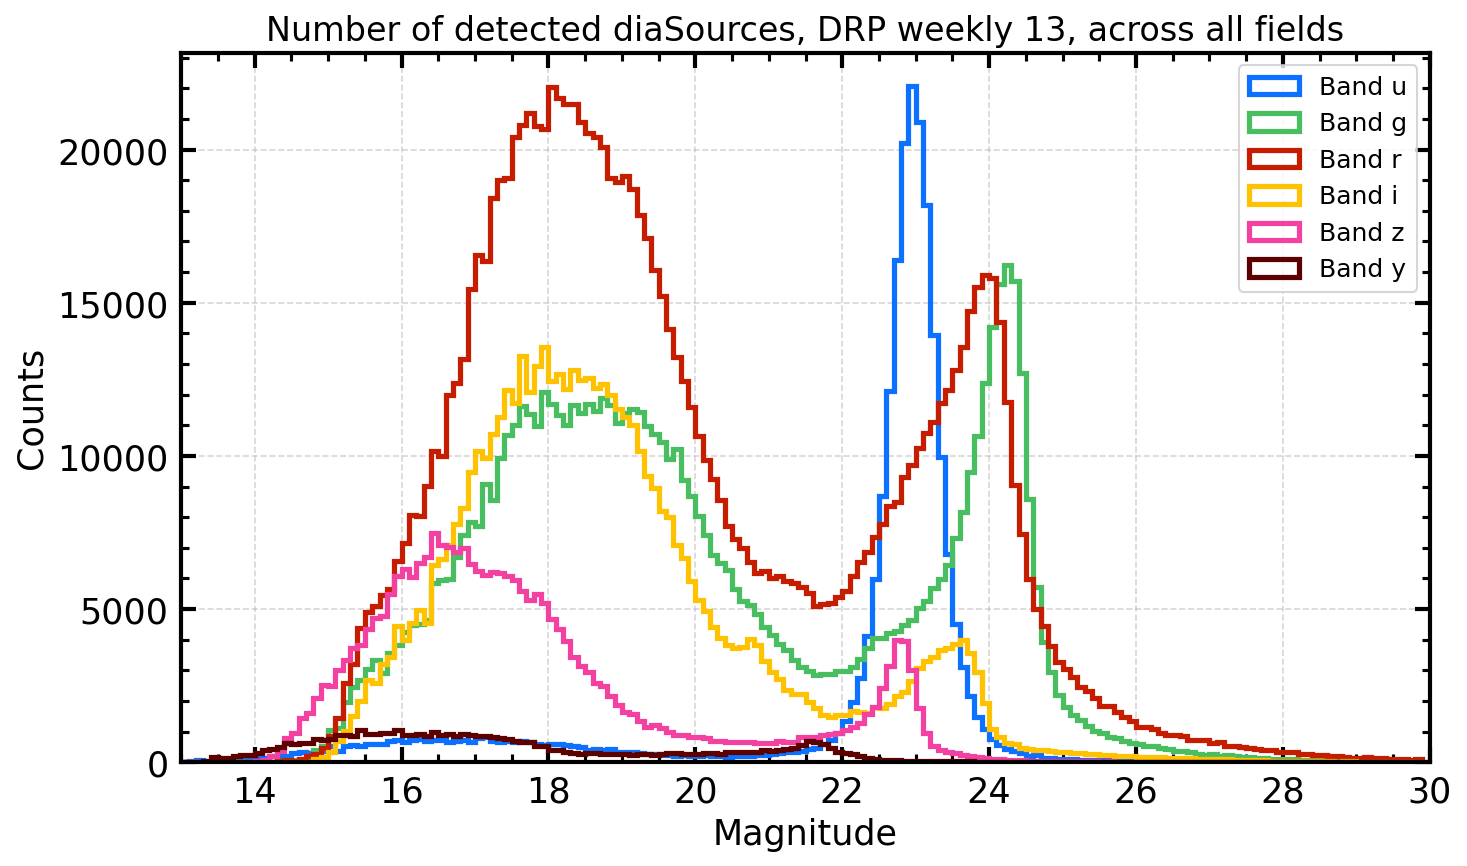

In [ ]:
publication_plots.set_rubin_plotstyle()
bands_dict = publication_plots.get_band_dicts()

# Define your bands (adjust to your actual values if needed)
bands = ["u", "g", "r", "i", "z", "y"]

# Plot: one figure, six lines (one per band)
plt.figure(figsize=(10, 6))
plt.title('Number of detected diaSources, DRP weekly 13, across all fields', fontsize=16)

for band in bands:
    band_data = diaSource[diaSource['band'] == band]
    
    if not band_data.empty:
        plt.hist(
            band_data['scienceMag'],
            bins=np.arange(13, 30, 0.1),
            histtype='step',
            linewidth=2.5,
            color=bands_dict['colors'][band],  # Use the color corresponding to the band        
            label=f'Band {band}'
        )

# Plot formatting
plt.xlabel('Magnitude')
plt.ylabel('Counts')
plt.xlim(13, 30)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()